# Import Data

In [1]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.optim as optimr

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE

In [2]:
zip_path = "ALLFLOWMETER_HIKARI2021.zip"

with zipfile.ZipFile(zip_path, 'r') as zipped_file:
    csv_file_name = zipped_file.namelist()[0]

    with zipped_file.open(csv_file_name) as csv_file:
        df = pd.read_csv(csv_file)

In [3]:
df.head()

,Unnamed: 0.1,Unnamed: 0,uid,originh,originp,responh,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,0,0,Cg61Jch3vdz9DBptj,103.255.15.23,13316,128.199.242.104,443,2.207588,15,14,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,1
1,1,1,CdRIlqLWdj35Y9vW9,103.255.15.23,13318,128.199.242.104,443,15.624266,15,14,...,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,1
2,2,2,CLzp9Khd0Y09Qkgrg,103.255.15.23,13320,128.199.242.104,443,12.203357,14,13,...,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,1
3,3,3,Cnf1YA4iLB4CSNWB88,103.255.15.23,13322,128.199.242.104,443,9.992448,14,13,...,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,1
4,4,4,C4ZKvv3fpO72EAOsJ6,103.255.15.23,13324,128.199.242.104,443,7.780611,14,14,...,7.545305e+06,7.545305e+06,7.545305e+06,7.545305e+06,0.0,29200,65160,0,Bruteforce-XML,1


# Data Preprocessing

## Feature Selection

In [4]:
drop_label = ['Unnamed: 0.1', 'Unnamed: 0', 'uid', 'Label']
df = df.drop(labels=drop_label, axis=1)
df.head()

,originh,originp,responh,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category
0,103.255.15.23,13316,128.199.242.104,443,2.207588,15,14,6,6,6.794746,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML
1,103.255.15.23,13318,128.199.242.104,443,15.624266,15,14,6,6,0.960045,...,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML
2,103.255.15.23,13320,128.199.242.104,443,12.203357,14,13,6,5,1.147225,...,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML
3,103.255.15.23,13322,128.199.242.104,443,9.992448,14,13,6,5,1.401058,...,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML
4,103.255.15.23,13324,128.199.242.104,443,7.780611,14,14,6,5,1.799345,...,126016.885411,7.545305e+06,7.545305e+06,7.545305e+06,7.545305e+06,0.0,29200,65160,0,Bruteforce-XML


In [5]:
df['traffic_category'].unique()

array(['Bruteforce-XML', 'Bruteforce', 'Background', 'Benign', 'Probing',
       'XMRIGCC CryptoMiner'], dtype=object)

In [6]:
numerical_features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_features = df.select_dtypes(include=["object", "category"]).columns.tolist()

## Encoding

One-hot untuk target, fitur lain menggunakan label encoding

In [7]:
encoder_label = LabelEncoder()

for col in categorical_features:
    df[col] = encoder_label.fit_transform(df[col])


## Z-Score Standarization

In [8]:
zscore = StandardScaler()

def Standarization(df):
    df_zscore = zscore.fit_transform(df)
    df = pd.DataFrame(df_zscore, columns=df.columns)
    return df

## MinMax Normalization

In [9]:
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [10]:
df['traffic_category'].nunique()


6

# Load Generator Model

In [11]:
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, data_dim):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, latent_dim)
        self.model = nn.Sequential(
            nn.Linear(latent_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, data_dim),
            nn.Sigmoid()
        )

    def forward(self, noise, labels):
        label_input = self.label_embedding(labels)
        gen_input = torch.cat((noise, label_input), dim=1)
        return self.model(gen_input)


In [12]:
# Pisahkan fitur dan label
X = df.drop(columns=['traffic_category'])  # Fitur
y = df['traffic_category']  # Label

# Konversi DataFrame ke numpy array
X = X.to_numpy()
y = y.to_numpy()

In [13]:
# Parameter untuk generator
latent_dim = 10  # Harus sama dengan yang digunakan saat training
num_classes = 6  # Jumlah kelas (sesuai dengan data Anda)
data_dim = X.shape[1]  # Dimensi data fitur
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inisialisasi model generator
generator = Generator(latent_dim, num_classes, data_dim).to(device)

# Muat bobot model
generator.load_state_dict(torch.load("generator_cgan.pth", map_location=device))
generator.eval()  # Mode evaluasi


C:\Users\mradi\AppData\Local\Temp\ipykernel_12988\1414559857.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator_cgan.pth", 

Generator(
  (label_embedding): Embedding(6, 10)
  (model): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=83, bias=True)
    (3): Sigmoid()
  )
)

In [14]:
def generate_synthetic_data(generator, num_samples, class_label, latent_dim, device):
    # Noise random
    noise = torch.randn((num_samples, latent_dim), device=device)
    # Label dalam format long tensor
    labels = torch.tensor([class_label] * num_samples, dtype=torch.long, device=device)
    # Generasi data sintetis
    synthetic_data = generator(noise, labels).detach().cpu().numpy()
    return synthetic_data


In [15]:
import numpy as np

# Hitung jumlah data untuk kelas mayoritas
major_class_count = max(np.bincount(y))

X_synthetic = []
y_synthetic = []

for class_label in np.unique(y):
    current_class_count = (y == class_label).sum()
    num_samples_needed = major_class_count - current_class_count

    if num_samples_needed > 0:
        synthetic_data = generate_synthetic_data(generator, num_samples_needed, class_label, latent_dim, device)
        X_synthetic.append(synthetic_data)
        y_synthetic.append(np.full(num_samples_needed, class_label))

X_synthetic = np.vstack(X_synthetic)
y_synthetic = np.concatenate(y_synthetic)

# Gabungkan data asli dan sintetis
X_balanced = np.vstack([X, X_synthetic])
y_balanced = np.concatenate([y, y_synthetic])


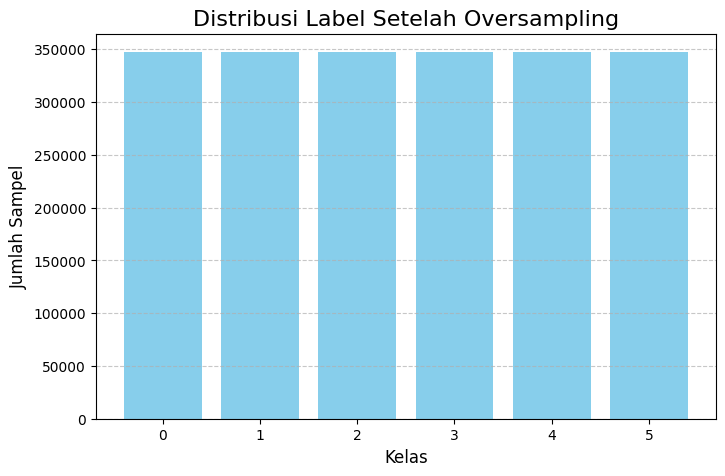

In [16]:
# Plot distribusi
plt.figure(figsize=(8, 5))
unique, counts = np.unique(y_balanced, return_counts=True)
plt.bar(unique, counts, color='skyblue')
plt.title("Distribusi Label Setelah Oversampling", fontsize=16)
plt.xlabel("Kelas", fontsize=12)
plt.ylabel("Jumlah Sampel", fontsize=12)
plt.xticks(unique)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Split data untuk training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# Inisialisasi RandomForest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Training
rf_model.fit(X_train, y_train)

# Prediksi
y_pred = rf_model.predict(X_test)

# Evaluasi
print("Akurasi:", accuracy_score(y_test, y_pred))
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred))
